# About

Script to generate the figures pertaining to large-N dimensional numerics. Shows the plots over time for a single trial, and a compiled plot showing where multiple trials converge in terms of asymptotic frequency and variance. Import .mat files generated from 'sec4_ND_numerics.m'.

# Library

In [1]:
from __future__ import division, print_function

%matplotlib inline
# Toggle on/off
# %matplotlib notebook

import os
import numpy as np
import scipy.io as sio
from scipy import optimize
import scipy.integrate as integrate
from scipy import stats
import matplotlib.cm as cm
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import matplotlib.transforms as tsfm
import math
from math import pi

from lib import *

from IPython.display import clear_output

# Directories

In [2]:
# Data files (for fig.4d)
import_folder = 'sec4_ND_numerics'

# Directory
dir_main = os.getcwd()
dir_im = os.path.join(dir_main, 'matlab', 'data', import_folder)

filenames = os.listdir(dir_im)
filenames.remove('parameters.mat')

# Import data

## Parameters

In [3]:
dir_par = os.path.join(dir_im, 'parameters.mat')
dict_par = sio.loadmat(dir_par)

N = dict_par['N'][0,0]
g = dict_par['g'][0,0]
w0 = dict_par['omega0'][0,0]
alphatau = dict_par['alphatau'][0,0]
gain = dict_par['gain'][0,0]
tau0 = dict_par['tau0'][0,0]
t0 = dict_par['t0'][0,0]
tf = dict_par['tf'][0,0]
epsilon = dict_par['epsilon'][0,0]

std_upper = dict_par['L_std'][0,0]
freq_upper = dict_par['L_freq'][0,0] * g

asy = dict_par['asy'][0,0]

logtol = dict_par['logtol'][0,0]
rerange = np.reshape(dict_par['rerange'], -1)
imrange = np.reshape(dict_par['imrange'], -1)

## Theoretical functions

Obtain the theoretical curve $\Omega = \Omega(\delta)$ using arcsin, and obtain the optimal deviation $\delta$.

In [4]:
# Fixed-point function
def Omega_sync(phi, parameters):
    '''
    Returns the array of potential synchronization frequencies at delta. Uses summation instead of integral.
    '''
    
    # Parameters
    g = parameters['g']
    w0 = parameters['omega0']
    gain = parameters['gain']
    tau0 = parameters['tau0']
    N = parameters['N']
    
    # Define root function
    # SUM = lambda u: np.sum(np.sin(-u*np.maximum(tau0 + gain*np.sin(phi), np.zeros(phi.shape)) + phi))
    Delta = np.subtract.outer(phi, phi)
    SUM = lambda u: np.sum(np.sin(-u*np.maximum(tau0 + gain*np.sin(Delta), np.zeros(Delta.shape)) + Delta))
    
    Omega_fun = lambda u: u - w0 - g*SUM(u) / N**2
    
    # Determine all Omegas in [w0-g, w0+g]
    Omegas = rootlib.root_on_interval(Omega_fun, w0-g, w0+g, steps=500)
    
    return Omegas

    
# Least-squared error arcsin fit
def arcsin_delta(phi):
    '''
    Given an array of phases between -pi/2 and pi/2, fit the least squared error for 2*delta/pi*arcsin(phi) and return
    optimal delta.
    '''
    
    # Sort and center phi at 0
    phi0 = np.sort(phi) - np.mean(phi)
    
    # Least error function
    x_arr = np.linspace(-1,1, phi0.size)
    errfun = lambda delta: np.sum((phi0 - delta*np.arcsin(x_arr))**2)
    
    # Obtain minimal delta
    delta_arr = np.linspace(0,1,1000)
    err_arr = np.ones(delta_arr.shape)
    
    for k in range(delta_arr.size):
        delta0 = delta_arr[k]
        err_arr[k] = errfun(delta0)
    
    ind_opt = np.argmin(err_arr)
    
    return delta_arr[ind_opt]

## Theoretical arrays

Implement functions above to obtain theoretical results and fits on the numerical data.

In [5]:
# Bifurcation point
delta_c = 0.033

# Fixed-point function
parameters = {'N': N, 'g': g, 'omega0': w0, 'gain': gain, 'tau0': tau0}
Omegafun = lambda Omega, delta: funlib.Omega_infty(Omega, delta, parameters, L=2*pi, steps=1000) - Omega

# Arrays
deltaarr = np.linspace(0,0.5, num=500)

# Plot 2 arrays
Omega_arr = np.empty((deltaarr.size, 30)) # Padded
Omega_arr[:] = np.nan
Omega_arr2 = np.zeros(deltaarr.shape)

maxRootCount = 0
for k in range(deltaarr.size):
    
    delta = deltaarr[k]
    
    Omegaerr = lambda u: Omegafun(u, np.sqrt(2)*delta)
    Omegaroots2 = rootlib.find_root(Omegaerr, w0, w0-g, w0+g, steps=500)
    if Omegaroots2[1]:
        Omega_arr2[k] = Omegaroots2[0]
        
        
    phis = delta*np.arcsin(np.linspace(-1,1,N))
    
    # Obtain array of roots
    Omegaroots = Omega_sync(phis, parameters)
    
    # Sort Omegaroots from smallest to largest
    Omegaroots = np.sort(Omegaroots)
    
    # Add to Omega array
    Omega_arr[k,:Omegaroots.size] = Omegaroots
    
    # Get maximum number of roots
    maxRootCount = max(maxRootCount, Omegaroots.size)

# Remove padding
Omega_arr = Omega_arr[:,:maxRootCount]

# Bifurcation point
ind_c = np.argmin(np.abs(deltaarr - delta_c))
Omega_c = Omega_arr2[ind_c]
delta_c = deltaarr[ind_c]

## Asymptotic values

In [6]:
# Chosen index
ind0 = 1

# Zero tolerance
zeroTol = 0.01

# Eigenvalues
is_eigs = False

# Compiled arrays
initOmegas = np.zeros(len(filenames))
initstds = np.zeros(len(filenames))
asyOmegas = np.zeros(len(filenames))
asydeltas = np.zeros(len(filenames))
asyPhis = np.zeros((N,len(filenames)))

maxReEigs = np.zeros(len(filenames))
maxErrs = np.zeros(len(filenames))

for i in range(len(filenames)):
    
    # Import .mat file
    filename = filenames[i]
    dir_mat = os.path.join(dir_im, filename)
    dict_mat =  sio.loadmat(dir_mat)
    
    # Get g, tau0 indices
    ind_file = filename.split('.')[0]
    ind = int(ind_file)
    
    # Compile solution dictionary
    sol = {'t': np.reshape(dict_mat['t'], -1),
           'y': dict_mat['y'],
           'yp': dict_mat['yp'],
           'tau': dict_mat['tau'],
           'taup': dict_mat['taup']
          }
    
    initOmega = dict_mat['hist_freq'][0,0]
    initstd = dict_mat['hist_std'][0,0]
    
    asyOmega = dict_mat['Omega_asy'][0,0]
    asyPhases = np.reshape(dict_mat['phases_asy'], -1)
    
    arrlinear = asyOmega*sol['t']
    arrlinear = arrlinear[:,None]
    arrphases = sol['y'] - arrlinear
    
    # asydelta = arcsin_delta(asyPhases)
    asydelta = np.sqrt(np.var(asyPhases))
    
    # Eigenvalues
    if is_eigs:
        eigs = np.reshape(dict_mat['eigs'], -1)
        eigs_nonzero = eigs[np.abs(eigs) > zeroTol]
        maxReEig = np.max(eigs_nonzero.real)
        errs = np.reshape(dict_mat['errors'], -1)
        maxErr = np.max(np.abs(errs))
    
    
    # If equal to an index, store the eigenvalue distribution
    if ind == ind0:
        sol0 = sol.copy()
        arrphases0 = arrphases
        asyOmega0 = asyOmega
        asyPhases0 = asyPhases
        asydelta0 = asydelta
        initOmega0 = initOmega
        initstd0 = initstd
    
    # Process asymptotic phases
    asyPhases = asylib.mod_pi(asyPhases)
    asyPhases = np.sort(asyPhases)
    asyPhases = asyPhases - np.mean(asyPhases)
    
    # Store other values
    initOmegas[i] = initOmega
    initstds[i] = initstd
    asyOmegas[i] = asyOmega
    asydeltas[i] = asydelta
    asyPhis[:,i] = asyPhases
    
    if is_eigs:
        maxReEigs[i] = maxReEig
        maxErrs[i] = maxErr
    
# Compute asyDeltas
asyDeltas0 = asyPhases0[:,np.newaxis] - asyPhases0
asyDeltas0 = np.reshape(asyDeltas0, -1)

# Gaussian curve fit
GaussFun = lambda x: (np.sqrt(4*pi*asydelta0**2))**(-1)*np.exp(-x**2/(4*asydelta0**2))
Deltas_arr = np.linspace(-pi, pi, num=1000)
Gauss_arr = GaussFun(Deltas_arr)
BINS = np.linspace(-pi/4, pi/4, num=50)

# Plot

## Options

In [7]:
bbox0 = [0.10, 0.7, 0.3, 0.20]  # Fig 2a: Derivative plots
bbox1 = [0.10, 0.4, 0.3, 0.20]  # Fig 2b: sin(phase) plots
bbox2 = [0.10, 0.1, 0.3, 0.20] # Fig 2c: Delay plots
bbox3 = [0.50, 0.1, 0.40, 0.5] # Fig 2e: Iterated trial plot
bbox4 = [0.50, 0.7, 0.40, 0.2] # Fig 2d: Histogram plot with Gaussian fit

# Figures A, B, C
linewidth1 = 1.2
alpha1 = 0.4

t0 = np.min(sol['t'])
tf = np.max(sol['t'])

# Linear array
phi_linear = 2*pi*np.arange(0,N)/N

# Histogram
lw_gauss = 1.0
col_gauss = 'blue'

lw_hist = 1.0
col_hist = 'orange'
alpha_hist = 0.5
col_hist2 = clr.to_rgba(col_hist, alpha=alpha_hist)

# Sample
num_inds = 50
inds = np.random.choice(np.arange(N**2-1), size=num_inds, replace=False)

## Generate figures

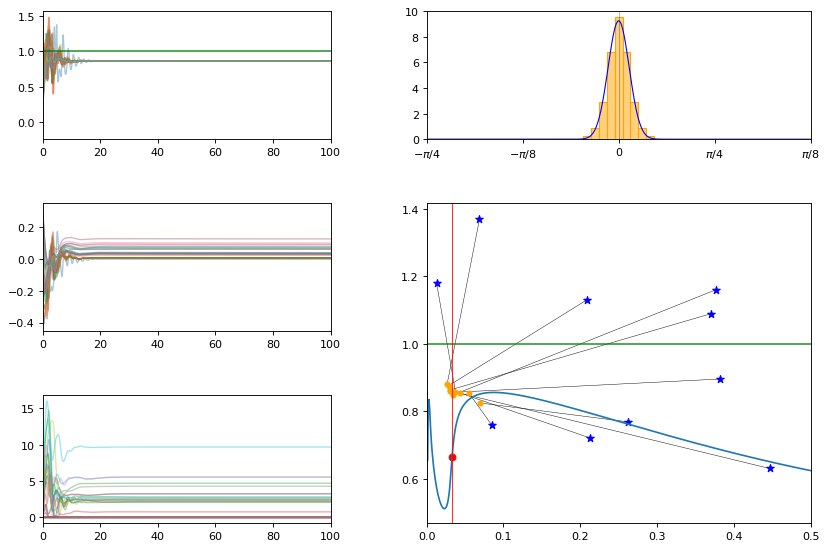

In [20]:
fig, ax = plt.subplots(5, figsize=(12,8), dpi=80)

# Set positions
ax[0].set_position(bbox0)
ax[1].set_position(bbox1)
ax[2].set_position(bbox2)
ax[3].set_position(bbox3)
ax[4].set_position(bbox4)

# Figures A, B, C (single trial)
ax[0].plot(sol0['t'], sol0['yp'], linewidth=linewidth1, alpha=alpha1, zorder=2)
ax[1].plot(sol0['t'], np.sin(arrphases0), linewidth=linewidth1, alpha=alpha1, zorder=2)
ax[2].plot(sol0['t'], sol0['tau'][:,inds], linewidth=linewidth1, alpha=alpha1, zorder=2)

# Figure D
ax[4].hist(asyDeltas0, bins=BINS, density=True, color=col_hist2, edgecolor=col_hist, linewidth=lw_hist, zorder=1)
ax[4].plot(Deltas_arr, Gauss_arr, color=col_gauss, linewidth=lw_gauss, zorder=2) 
ax[4].set_xticks(np.array([-pi/4, -pi/8, 0, pi/4, pi/8]))
ax[4].set_xticklabels([r'$-\pi / 4$', r'$-\pi / 8$', '0', r'$\pi / 8$', r'$\pi / 4$'])

# Figure E
ax[3].plot(deltaarr, Omega_arr2)
ax[3].scatter(delta_c, Omega_c, color='red', zorder=2)
ax[3].scatter(initstds, initOmegas, color='blue', marker='*', s=50, zorder=2)
ax[3].scatter(asydeltas, asyOmegas, color='orange', s=20, zorder=2)


for k in range(initOmegas.size):
    p1 = np.array([initOmegas[k], asyOmegas[k]])
    p2 = np.array([initstds[k], asydeltas[k]])
    ax[3].plot(p2, p1, color='black', linewidth=0.4, zorder=1)
    
# Edit plots
tf_show = tf/5
ax[0].set_xlim(left=t0, right=tf_show)
ax[1].set_xlim(left=t0, right=tf_show)
ax[2].set_xlim(left=t0, right=tf_show)
ax[3].set_xlim(left=0, right=0.5)
ax[4].set_xlim(left=-pi/4, right=pi/4)

ax[0].axhline(y=w0, color='green', alpha=0.8, linewidth=1.5)
ax[3].axhline(y=w0, color='green', alpha=0.8, linewidth=1.5)
ax[3].axvline(x=0, color='black', alpha=0.8, linewidth=0.5)
ax[3].axvline(x=delta_c, color='red', alpha=0.8, linewidth=1.0)
ax[4].axvline(x=0, color='black', alpha=0.5, linewidth=0.5)

# Statistics

In [9]:
print(f'Asymptotic frequency = {asyOmega0}\n\
Asymptotic std = {asydelta0}\n\
Initial Omega = {initOmega0}\n\
Initial std = {initstd0}')
print(parameters)

Asymptotic frequency = 0.8629069570255054
Asymptotic std = 0.03047905197142943
Initial Omega = 1.0889895570594907
Initial std = 0.369895920490658
{'N': 40, 'g': 1.5, 'omega0': 1, 'gain': 80, 'tau0': 0.1}


In [10]:
phi = asyPhis[:,1]
Omega0 = asyOmega0
# Omega0 = 0.72899254
Delta = np.subtract.outer(phi, phi).T
SUM = np.sum(np.sin(-Omega0*np.maximum(tau0 + gain*np.sin(Delta), np.zeros(Delta.shape)) + Delta))
w0 + g*SUM / N**2

0.749783420440081

In [11]:
asydeltas, asyOmegas

(array([0.02875299, 0.03047905, 0.03087468, 0.03752901, 0.02673031,
        0.04341423, 0.03292628, 0.06913453, 0.03403195, 0.05526255]),
 array([0.87581632, 0.86290696, 0.86042465, 0.85799808, 0.88100687,
        0.85405655, 0.85565926, 0.82442285, 0.84775494, 0.85312621]))

In [12]:
initOmegas, initstds

(array([1.12954525, 1.08898956, 0.63013457, 1.18016914, 1.36880161,
        0.72113602, 0.89543707, 0.76830495, 1.16079825, 0.75840026]),
 array([0.20816593, 0.36989592, 0.4464774 , 0.01292665, 0.06878151,
        0.21204372, 0.38228339, 0.26221859, 0.37724068, 0.08489922]))